In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import re

In [31]:
dbfile = "chinook.db"
conn = sqlite3.connect(dbfile)
cursor = conn.cursor()

df = pd.read_sql_query("SELECT invoice_line_id, e.Invoice_id, e.Track_id, e.quantity, \
                       e.unit_price, e.genre_name, e.media_type_id, f.customer_id, f.invoice_date  FROM\
(\
\
(SELECT a.invoice_line_id, a.Invoice_id, a.Track_id, quantity, unit_price, genre_name, media_type_id FROM \
((SELECT Invoice_id, invoice_line_id, Track_id, quantity, unit_price from invoice_line) as a\
	JOIN\
	(SELECT track_id, genre_name, media_type_id from (\
	\
		(SELECT track_id, genre_id, media_type_id from track \
		WHERE media_type_id in (1,2,4,5)) as c \
		JOIN\
		(SELECT genre_id, name as genre_name from genre) as d\
		ON c.genre_id = d.genre_id)\
	\
	\
	) as b\
	ON a.track_id = b.track_id)) as e\
	JOIN\
	(select * from invoice where ((invoice_date >= '2020-01-01 00:00:00') and (invoice_date < '2021-01-01 00:00:00'))) as f\
	ON e.invoice_id = f.invoice_id\
	\
	) \
;", conn)
conn.close()

In [39]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['invoice_date'] = df['invoice_date'].dt.normalize() - pd.offsets.MonthBegin(1)

In [45]:
df = df.drop("quantity", axis=1)
df = df.drop("media_type_id", axis=1)

In [52]:
df.unit_price.value_counts()

0.99    1150
Name: unit_price, dtype: int64

In [49]:
genre_name_list = [
    'Rock', 'Alternative & Punk', 'Metal', 'Alternative', 'Heavy Metal']
df['genre_name'] = df['genre_name'].apply(lambda x : 'rock' if x in genre_name_list else 'others')

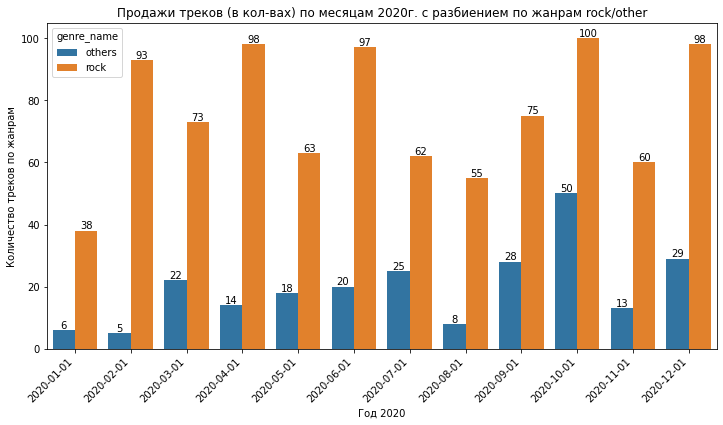

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,6))
df1 = df.groupby(['genre_name', 'invoice_date']).agg(mean_total_bill=("genre_name", 'count'))
df1 = df1.reset_index()
  
# plot barplot
sns.barplot(x='invoice_date',
            y='mean_total_bill',
            hue="genre_name",
           data=df1)
 #ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
x_dates = df1['invoice_date'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set_title('Продажи треков (в кол-вах) по месяцам 2020г. с разбиением по жанрам rock/other')
ax.set_xlabel('Год 2020')
ax.set_ylabel('Количество треков по жанрам')
for i in ax.containers:
    ax.bar_label(i,)

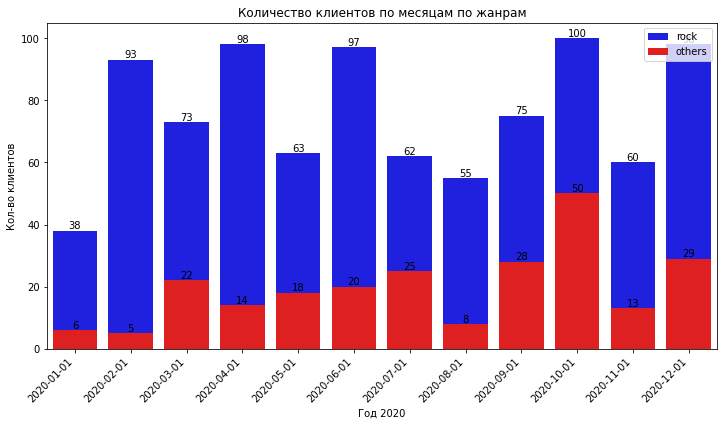

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,6))
df1 = df[df['genre_name']=='rock']
df1 = df1.groupby(['invoice_date']).agg(mean_total_bill=("customer_id", 'count'))
df1 = df1.reset_index()

df2 = df[df['genre_name']=='others']
df2 = df2.groupby(['invoice_date']).agg(mean_total_bill2=("customer_id", 'count'))
df2 = df2.reset_index()
 
# plot barplot
sns.barplot(x='invoice_date',
            y='mean_total_bill',
           data=df1,
          label='rock',
           color='blue')

sns.barplot(x='invoice_date',
            y='mean_total_bill2',
           data=df2,
           label='others',
           color = 'red')


#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
x_dates = df1['invoice_date'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set_title('Количество клиентов по месяцам по жанрам')
ax.set_xlabel('Год 2020')
ax.set_ylabel('Кол-во клиентов')
for i in ax.containers:
    ax.bar_label(i,)
ax.legend()

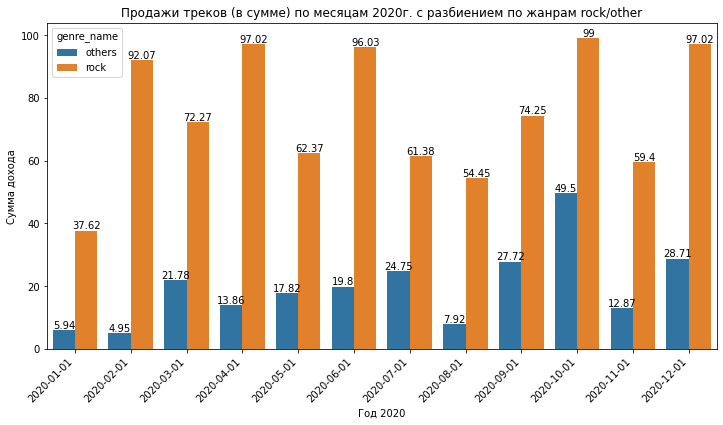

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,6))
df1 = df.groupby(['genre_name', 'invoice_date']).agg(mean_total_bill=("unit_price", 'sum'))
df1 = df1.reset_index()
  
# plot barplot
sns.barplot(x='invoice_date',
            y='mean_total_bill',
            hue="genre_name",
           data=df1)
 #ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
x_dates = df1['invoice_date'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set_title('Продажи треков (в сумме) по месяцам 2020г. с разбиением по жанрам rock/other')
ax.set_xlabel('Год 2020')
ax.set_ylabel('Сумма дохода')
for i in ax.containers:
    ax.bar_label(i,)

## Выводы:
### 1. Продажи по товарам в жанре rock по всему году лидируют и в количественном, и встоимостном выражении (в количественном в стоимостно выражении в 2-3 раза продажи rock выше)
### 2. Есть восходящий тренд по продажам в жанре others, в тоже время продаже в жанре rock не растут.
### 3. Есть сезонное падение в начале года по обоим жанрам. 